# Домашнее задание для Junior DS по разработке PD модели

<b>Задание:</b> Необходиом разработать модель предсказания дефолта. Даны финансовые данные 32 395 компаний (выручка, активы, пассивы и т.д). Результат будет оцениваться на скрытой выборке из 200 компаний по метрике качества accuracy_score

<b>Цель задания</b> научиться / показать знания в разработке моделей оценки риска - probability of default. Задание приближено к реальному, данные синтетические. Лидерборд для оценки собственного решения и геймификации процесса обучения. Первое место в лидерборде не явлется целью. Цель - правильно разарботанная модель, удовлетворяющая требованиям банковской системы. В случае возникновения вопросов, сотрудники блока Риски готовы проконсультировать и дать обратную связь на модель (телеграм чат).

<b>Метрика качества</b> accuracy_score вычисляется, как ( True positive + True negative ) / Total. Если сабмит-файл, не правильного формата или неверное количество строк, метрика будет = 0.

### Импортируем библиотеки

In [2]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

### Подгружаем данные

In [3]:
!wget https://raw.githubusercontent.com/BKHV/risk_models/master/data/PD-data-train.csv
!wget https://raw.githubusercontent.com/BKHV/risk_models/master/data/PD-data-test.csv
!wget https://raw.githubusercontent.com/BKHV/risk_models/master/data/PD-data-desc.csv

--2022-09-26 17:19:20--  https://raw.githubusercontent.com/BKHV/risk_models/master/data/PD-data-train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5329268 (5.1M) [text/plain]
Saving to: ‘PD-data-train.csv’

PD-data-train.csv   100%[===================>]   5.08M  --.-KB/s    in 0.02s   

2022-09-26 17:19:20 (293 MB/s) - ‘PD-data-train.csv’ saved [5329268/5329268]

--2022-09-26 17:19:20--  https://raw.githubusercontent.com/BKHV/risk_models/master/data/PD-data-test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28259 (28K

In [13]:
train_df = pd.read_csv('PD-data-train.csv', sep=';')
test_df = pd.read_csv('PD-data-test.csv', sep=';')
desc_df = pd.read_csv('PD-data-desc.csv', sep=';')

Количество разных типов фичей

In [9]:
train_df.dtypes.value_counts()

float64    25
int64      11
object      1
dtype: int64

Уровень дефолт-рейта в выборке = 6,7219%

In [10]:
train_df['default_12m'].values.mean()

0.06454699799351751

In [11]:
train_df.record_id.nunique()

32395

32395 уникальных наблюдений

Изучение признаков

In [25]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32395 entries, 0 to 32394
Data columns (total 37 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   record_id                     32395 non-null  int64  
 1   ar_revenue                    17250 non-null  float64
 2   ar_total_expenses             17250 non-null  float64
 3   ar_sale_cost                  17250 non-null  float64
 4   ar_selling_expenses           17250 non-null  float64
 5   ar_management_expenses        17250 non-null  float64
 6   ar_sale_profit                17250 non-null  float64
 7   ar_balance_of_rvns_and_expns  17250 non-null  float64
 8   ar_profit_before_tax          17250 non-null  float64
 9   ar_taxes                      17250 non-null  float64
 10  ar_other_profit_and_losses    17250 non-null  float64
 11  ar_net_profit                 17250 non-null  float64
 12  ab_immobilized_assets         17250 non-null  float64
 13  a

In [14]:
train_df = train_df.fillna(0)
test_df = train_df.fillna(0)

In [32]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32395 entries, 0 to 32394
Data columns (total 37 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   record_id                     32395 non-null  int64  
 1   ar_revenue                    32395 non-null  float64
 2   ar_total_expenses             32395 non-null  float64
 3   ar_sale_cost                  32395 non-null  float64
 4   ar_selling_expenses           32395 non-null  float64
 5   ar_management_expenses        32395 non-null  float64
 6   ar_sale_profit                32395 non-null  float64
 7   ar_balance_of_rvns_and_expns  32395 non-null  float64
 8   ar_profit_before_tax          32395 non-null  float64
 9   ar_taxes                      32395 non-null  float64
 10  ar_other_profit_and_losses    32395 non-null  float64
 11  ar_net_profit                 32395 non-null  float64
 12  ab_immobilized_assets         32395 non-null  float64
 13  a

Работа с категориальными фичами: в данном датасете только одна, применяем к ней one hot encoding

In [15]:
train_df['ul_staff_range'].unique()

array(['[1-100]', '(100-500]', '> 500'], dtype=object)

In [16]:
y = pd.get_dummies(train_df['ul_staff_range'])
train_df = train_df.drop('ul_staff_range', axis = 1)
train_df = train_df.join(y)

y = pd.get_dummies(test_df['ul_staff_range'])
test_df = test_df.drop('ul_staff_range', axis = 1)
test_df =  test_df.join(y)

Уменьшим количество фичей для упрощения работы модели и увеличении ее эффективности: найдем те, что коррелируют друг с другом и оставим только по одному экземпляру

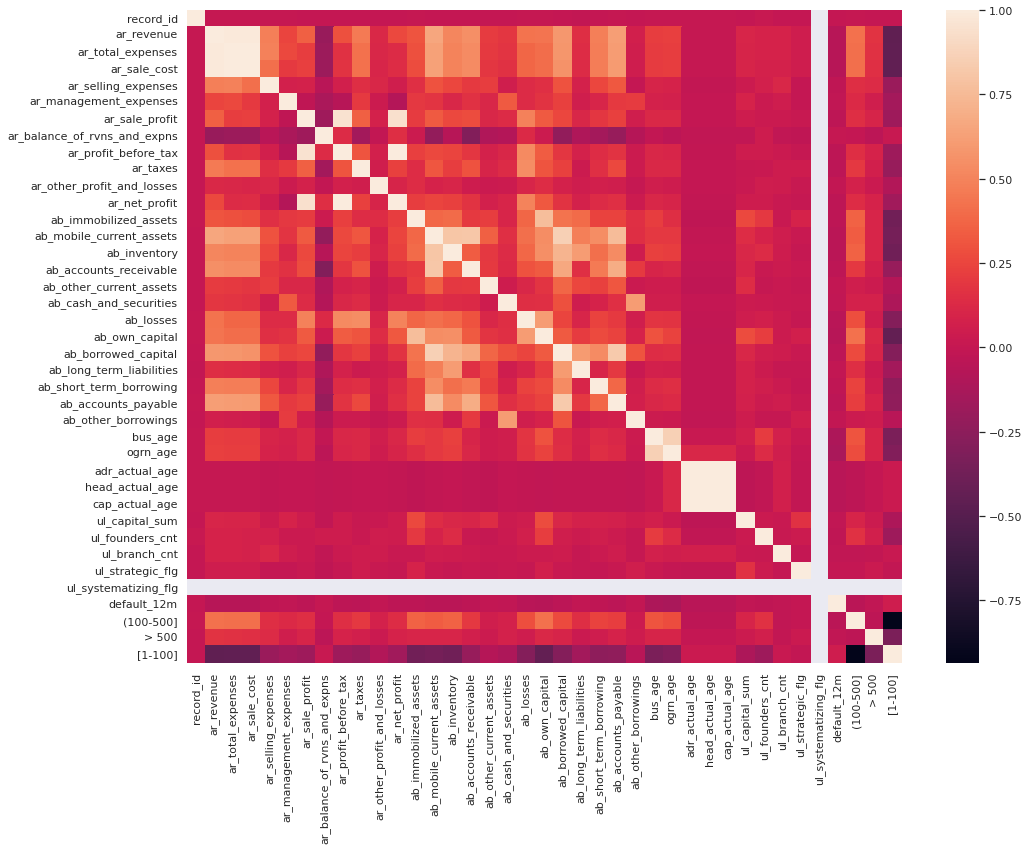

In [17]:
sns.set(rc={'figure.figsize':(16,12)})
sns.heatmap(train_df.corr())

id записи бесполезно, не несет в себе информации. Удаляю столбцы с высоким показателем корреляции с каким-либо из других признаков

In [18]:
drop_features = ['record_id', 'adr_actual_age', 'ar_revenue', 'ar_total_expenses', 
                 'head_actual_age', 'ab_mobile_current_assets',
                 'ul_systematizing_flg', 'ar_net_profit', 'ar_sale_profit', 
                 'bus_age', 'ab_borrowed_capital']

for feat in drop_features:
  train_df = train_df.drop(feat, axis = 1)
  test_df = test_df.drop(feat, axis = 1)

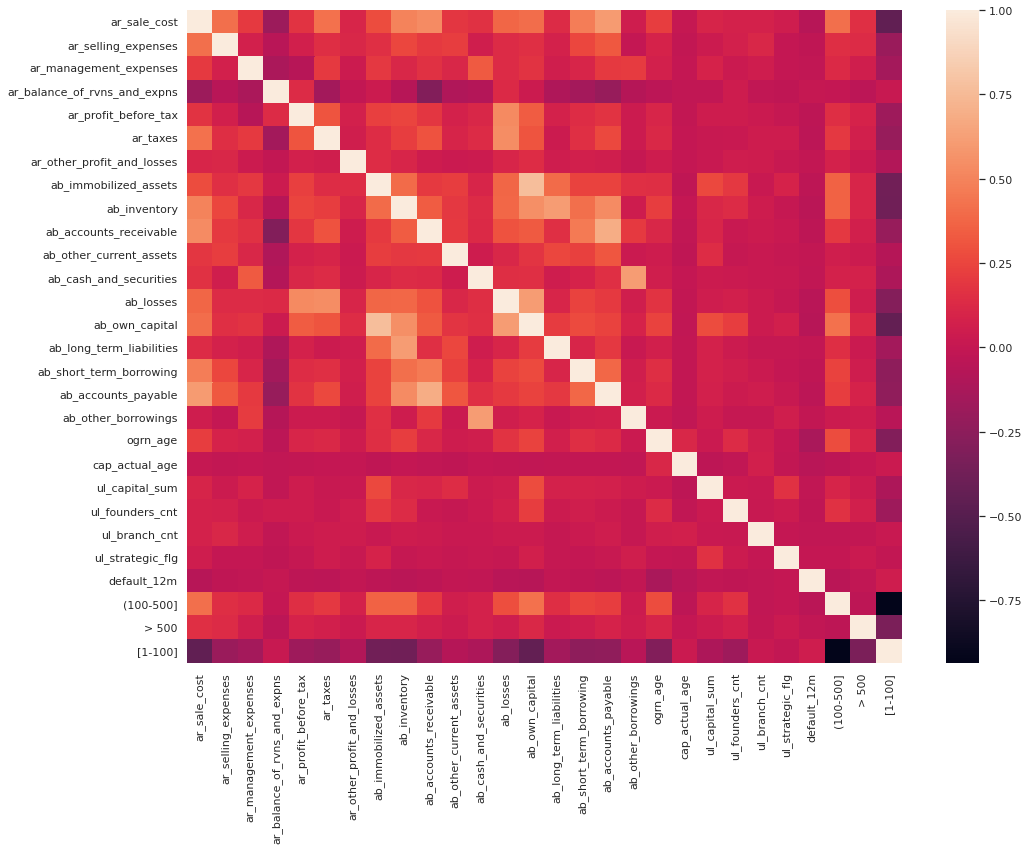

In [19]:
sns.set(rc={'figure.figsize':(16,12)})
sns.heatmap(train_df.corr())

Масштабирование численных признаков

In [20]:
from sklearn.preprocessing import StandardScaler

In [39]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32395 entries, 0 to 32394
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ar_sale_cost                  32395 non-null  float64
 1   ar_selling_expenses           32395 non-null  float64
 2   ar_management_expenses        32395 non-null  float64
 3   ar_balance_of_rvns_and_expns  32395 non-null  float64
 4   ar_profit_before_tax          32395 non-null  float64
 5   ar_taxes                      32395 non-null  float64
 6   ar_other_profit_and_losses    32395 non-null  float64
 7   ab_immobilized_assets         32395 non-null  float64
 8   ab_inventory                  32395 non-null  float64
 9   ab_accounts_receivable        32395 non-null  float64
 10  ab_other_current_assets       32395 non-null  float64
 11  ab_cash_and_securities        32395 non-null  float64
 12  ab_losses                     32395 non-null  float64
 13  a

In [25]:
num_cols = ['ar_sale_cost', 'ar_selling_expenses', 'ar_management_expenses',
       'ar_balance_of_rvns_and_expns', 'ar_profit_before_tax', 'ar_taxes',
       'ar_other_profit_and_losses', 'ab_immobilized_assets', 'ab_inventory',
       'ab_accounts_receivable', 'ab_other_current_assets',
       'ab_cash_and_securities', 'ab_losses', 'ab_own_capital',
       'ab_long_term_liabilities', 'ab_short_term_borrowing',
       'ab_accounts_payable', 'ab_other_borrowings', 'ogrn_age',
       'cap_actual_age', 'ul_capital_sum', 'ul_founders_cnt', 'ul_branch_cnt',
       'ul_strategic_flg']

cat_cols = ['(100-500]', '> 500', '[1-100]']

In [30]:
pca = StandardScaler()
pca.fit(train_df[num_cols])
# Выход pca - numpy матрица, положим ее в новую переменную со всеми фичами
print(train_df.shape)
X_dig_train = pd.DataFrame(pca.transform(train_df[num_cols]), columns = num_cols)
cat_train = train_df[cat_cols]
y_train = train_df['default_12m']
train_df = X_dig_train.join(cat_train)
train_df = train_df.join(y_train)
print(train_df.shape)

print(test_df.shape)
X_dig_test = pd.DataFrame(pca.transform(test_df[num_cols]), columns = num_cols)
cat_test = test_df[cat_cols]
y_test = test_df['default_12m']
test_df = X_dig_test.join(cat_test)
test_df = test_df.join(y_test)
print(test_df.shape)

(32395, 28)
(32395, 28)
(32395, 28)
(32395, 28)


### Валидация результата

In [31]:
X_train, X_test, y_train, y_test = train_test_split(train_df.drop('default_12m',axis=1),
                                                    train_df['default_12m'],
                                                    random_state=42, shuffle=True)

logit = LogisticRegression(penalty = 'l1', solver = 'liblinear', max_iter=1000)
logit.fit(X_train, y_train)
cv_baseline = cross_val_score(logit, X_train, y_train, cv=5, scoring='roc_auc').mean()
cv_baseline

0.6740078844823773

In [32]:
cv_baseline = cross_val_score(logit, X_test, y_test, cv=5, scoring='roc_auc').mean()
cv_baseline

0.6759675643602092

ROC/AUC бэйзлайн модели - 64,83%

### Попробуем другие модели

GridSearchCV помогает удобно перепробовать разные комбинации параметров моделей для выявления лучшей

In [10]:
from sklearn.model_selection import GridSearchCV

In [60]:
#1 модель - XGBRegressor
from xgboost import XGBRegressor

param = {
        'n_estimators': [100],
        'max_depth': [5,7,9,11,13,15,17,20],
        'random_state': [24, 48,2020],
        'min_child_weight': [1, 300],
    }

gbr_grid_search = GridSearchCV(XGBRegressor(), 
                               [param],
                               cv=5,
                               verbose=10)
gbr_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5; 1/48] START max_depth=5, min_child_weight=1, n_estimators=100, random_state=24
[16:35:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV 1/5; 1/48] END max_depth=5, min_child_weight=1, n_estimators=100, random_state=24;, score=0.036 total time=   2.9s
[CV 2/5; 1/48] START max_depth=5, min_child_weight=1, n_estimators=100, random_state=24
[16:35:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV 2/5; 1/48] END max_depth=5, min_child_weight=1, n_estimators=100, random_state=24;, score=0.039 total time=   2.9s
[CV 3/5; 1/48] START max_depth=5, min_child_weight=1, n_estimators=100, random_state=24
[16:35:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV 3/5; 1/48] END max_depth=5, min_child_weight=1, n_e

GridSearchCV(cv=5, estimator=XGBRegressor(),
             param_grid=[{'max_depth': [5, 7, 9, 11, 13, 15, 17, 20],
                          'min_child_weight': [1, 300], 'n_estimators': [100],
                          'random_state': [24, 48, 2020]}],
             verbose=10)

In [61]:
print(gbr_grid_search.best_params_)
print(gbr_grid_search.best_score_)
print(gbr_grid_search.best_estimator_)

{'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 100, 'random_state': 24}
0.040665218316743613
XGBRegressor(max_depth=7, random_state=24)


In [15]:
#2 модель - ElasticNet
from sklearn.linear_model import ElasticNet

param2 = {
        'alpha' : [0.1, 0.3, 0.5, 1],
        'max_iter': [1000],
        'random_state': [24, 48,2020],
        'tol': [0.0001, 0.001],
        'l1_ratio' : [0.001, 0.1, 0.5, 0.6, 1]
    }

gbr_grid_search = GridSearchCV(ElasticNet(), 
                               [param2],
                               cv=5,
                               verbose=10)
gbr_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV 1/5; 1/120] START alpha=0.1, l1_ratio=0.001, max_iter=1000, random_state=24, tol=0.0001
[CV 1/5; 1/120] END alpha=0.1, l1_ratio=0.001, max_iter=1000, random_state=24, tol=0.0001;, score=0.011 total time=   0.3s
[CV 2/5; 1/120] START alpha=0.1, l1_ratio=0.001, max_iter=1000, random_state=24, tol=0.0001
[CV 2/5; 1/120] END alpha=0.1, l1_ratio=0.001, max_iter=1000, random_state=24, tol=0.0001;, score=0.020 total time=   0.2s
[CV 3/5; 1/120] START alpha=0.1, l1_ratio=0.001, max_iter=1000, random_state=24, tol=0.0001
[CV 3/5; 1/120] END alpha=0.1, l1_ratio=0.001, max_iter=1000, random_state=24, tol=0.0001;, score=0.017 total time=   0.3s
[CV 4/5; 1/120] START alpha=0.1, l1_ratio=0.001, max_iter=1000, random_state=24, tol=0.0001
[CV 4/5; 1/120] END alpha=0.1, l1_ratio=0.001, max_iter=1000, random_state=24, tol=0.0001;, score=0.022 total time=   0.2s
[CV 5/5; 1/120] START alpha=0.1, l1_ratio=0.001, max_iter=1000, random_state=

GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid=[{'alpha': [0.1, 0.3, 0.5, 1],
                          'l1_ratio': [0.001, 0.1, 0.5, 0.6, 1],
                          'max_iter': [1000], 'random_state': [24, 48, 2020],
                          'tol': [0.0001, 0.001]}],
             verbose=10)

In [16]:
print(gbr_grid_search.best_params_)
print(gbr_grid_search.best_score_)
print(gbr_grid_search.best_estimator_)

{'alpha': 0.1, 'l1_ratio': 0.001, 'max_iter': 1000, 'random_state': 24, 'tol': 0.001}
0.01800069417103576
ElasticNet(alpha=0.1, l1_ratio=0.001, random_state=24, tol=0.001)


In [33]:
!pip3 install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.8 MB 1.1 MB/s 


In [34]:
from catboost import CatBoostRegressor

In [27]:
param3 = {'learning_rate' : [0.001, 0.0001],
          'n_estimators': [100],
          'max_depth': [5,7,9,11,13,15,17,20],
          'random_state': [24, 48, 2020],
          "loss_function": ["RMSE"],
          "verbose": [False]}

gbr_grid_search = GridSearchCV(CatBoostRegressor(), 
                               [param3],
                               cv=5)
gbr_grid_search.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
60 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/catboost/core.py", line 5593, in fit
    save_snapshot, snapshot_file, snapshot_interval, init_model, callbacks, log_cout, log_cerr)
  File "/usr/local/lib/python3.7/dist-packages/catboost/core.py", line 2270, in _fit
    callbacks=callbacks
  File "/usr/local/lib/pytho

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x7fb0e9abf350>,
             param_grid=[{'learning_rate': [0.001, 0.0001],
                          'loss_function': ['RMSE'],
                          'max_depth': [5, 7, 9, 11, 13, 15, 17, 20],
                          'n_estimators': [100], 'random_state': [24, 48, 2020],
                          'verbose': [False]}])

In [28]:
print(gbr_grid_search.best_params_)
print(gbr_grid_search.best_score_)
print(gbr_grid_search.best_estimator_)

{'learning_rate': 0.001, 'loss_function': 'RMSE', 'max_depth': 15, 'n_estimators': 100, 'random_state': 2020, 'verbose': False}
0.005401644017540219


Наименьшие показатели лосса у catboost, выбираем его

In [47]:
best_model = CatBoostRegressor(learning_rate = 0.001, loss_function = 'RMSE', max_depth = 15, n_estimators = 100, random_state = 2020, verbose = True)

In [48]:
best_model.fit(X_train, y_train, plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.2473609	total: 2.74s	remaining: 4m 31s
1:	learn: 0.2473455	total: 5.49s	remaining: 4m 28s
2:	learn: 0.2473323	total: 8.23s	remaining: 4m 26s
3:	learn: 0.2473191	total: 11.1s	remaining: 4m 26s
4:	learn: 0.2473034	total: 14.3s	remaining: 4m 31s
5:	learn: 0.2472846	total: 17.1s	remaining: 4m 27s
6:	learn: 0.2472712	total: 19.8s	remaining: 4m 23s
7:	learn: 0.2472572	total: 22.6s	remaining: 4m 19s
8:	learn: 0.2472445	total: 25.3s	remaining: 4m 15s
9:	learn: 0.2472293	total: 28s	remaining: 4m 12s
10:	learn: 0.2472119	total: 30.8s	remaining: 4m 8s
11:	learn: 0.2471944	total: 33.5s	remaining: 4m 5s
12:	learn: 0.2471782	total: 36.3s	remaining: 4m 2s
13:	learn: 0.2471648	total: 40.1s	remaining: 4m 6s
14:	learn: 0.2471509	total: 42.8s	remaining: 4m 2s
15:	learn: 0.2471339	total: 45.7s	remaining: 3m 59s
16:	learn: 0.2471202	total: 48.4s	remaining: 3m 56s
17:	learn: 0.2471041	total: 51.2s	remaining: 3m 53s
18:	learn: 0.2470880	total: 54s	remaining: 3m 50s
19:	learn: 0.2470744	total: 56.

In [49]:
from sklearn.metrics import roc_auc_score

In [50]:
roc_auc_score(y_train, best_model.predict(X_train))

0.8451429956354085

In [51]:
roc_auc_score(y_test, best_model.predict(X_test))

0.700103303066193

Также попробуем простейшую нейронную сеть. Solver lbfgs выбран ввиду маленького размера датасета, функция активации relu одна из лучших

In [52]:
from sklearn.neural_network import MLPRegressor

In [59]:
regr = MLPRegressor(activation = 'relu', solver = 'lbfgs', batch_size = 16, max_iter=5000, verbose = True).fit(X_train, y_train)

In [60]:
print(roc_auc_score(y_train, regr.predict(X_train)))
print(roc_auc_score(y_test, regr.predict(X_test)))

0.7698695356270012
0.6557547045663904


Результаты хуже чем у catboost, оставляем свой выбор на нем

### Формирование файла с ответом

In [44]:
drop_features = ['adr_actual_age', 'ar_revenue', 'ar_total_expenses', 
                 'head_actual_age', 'ab_mobile_current_assets',
                 'ul_systematizing_flg', 'ar_net_profit', 'ar_sale_profit', 
                 'bus_age', 'ab_borrowed_capital']

for feat in drop_features:
  train_df = train_df.drop(feat, axis = 1)
  test_df = test_df.drop(feat, axis = 1)

In [45]:
answ_df = test_df[['record_id']]

In [46]:
answ_df['id'] = answ_df['record_id']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [47]:
answ_df.drop('record_id',axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [48]:
cutoff = y_train.mean()

In [52]:
best_model.predict(test_df)

array([0.06188194, 0.0633633 , 0.06762886, ..., 0.07098035, 0.0936438 ,
       0.06168753])

In [54]:
answ_df['predict'] = (best_model.predict(test_df)>cutoff).astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [55]:
answ_df.to_csv('PD-submit.csv',index=False, sep=';')

In [61]:
!touch 'records.jsonl'

In [63]:
f=open('records.jsonl', "r+")
print(answ_df.to_json(orient='records', lines=True),file=f, flush=False)

Для загрузки своего рузультата на https://dsbattle.com/hackathons/juniords-new/ вам нужно создать csv файл с двумя колонками (id, predict), разделитель - точка с запятой (;)